In [1]:
%matplotlib inline

import numpy as np
from scipy import signal, ndimage, interpolate

import matplotlib.pyplot as plt
import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

from pathlib import Path
import os,sys
import h5py
import sys 

from circus.shared.parser import CircusParser
from circus.shared.files import load_data
import time

sys.path.append('../PreProcessing/')  
from get_neuralynx import *

/Users/alexgonzalez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
animal = 'Li'
task = 'OF'
date = '062718'

filename = animal+'_'+task+'_'+date+'_Results'
datPath=Path('/Users/alexgonzalez/Google Drive/PostDoc/Data/',task,animal,filename)
savePath=Path(datPath,'plots/spatial_tuning/')
savePath.mkdir(parents=True, exist_ok=True)
cwd = datPath.cwd()

In [3]:
# Read t,x,y
with h5py.File((datPath / 'VT1.h5'), 'r') as f:
    t = f.get('t').value
    x = f.get('x').value
    y = f.get('y').value


In [4]:
def smooth_hist2d(img,w,sigma=1.5):
    trunc = (((w - 1)/2)-0.5)/sigma
    return ndimage.filters.gaussian_filter(img,sigma,mode='constant',truncate=trunc)
    

### Occupancy Map

In [5]:
# original x/y limits
xlims_orig = np.array([65, 250])
ylims_orig = np.array([40, 180])

step = 5 # cm

# rotate, center and smooth.
x2 = y - ylims_orig.mean()
y2 = -x + xlims_orig.mean()
x2 = signal.medfilt(x2,13)
y2 = signal.medfilt(y2,13)
f_xy = interpolate.interp1d(t,np.array([x2,y2]), kind="nearest",fill_value="extrapolate")

pos = nept.Position(np.array([x2,y2]).T,t)

x2lims = [x2.min()+step, x2.max()]
y2lims = [y2.min()+2*step, y2.max()]
print(y2lims,x2lims)
xedges=np.arange(x2lims[0]-step,x2lims[1]+step,step)
yedges=np.arange(y2lims[0]-step,y2lims[1]+step,step)

position_2d, pos_yedges, pos_xedges = np.histogram2d(y2,x2, bins=[yedges, xedges])
# convert position occupancy to time. 
T = np.max(t)-np.min(t)
print('Total Time = ', T)
nBins = position_2d.size
print('Total number of bins = ', nBins)
nOccBin = position_2d.sum()
print('Total number of occupancy ticks = ', nOccBin)
bin2time = T/nOccBin;
print('Bin to Time conversion factor [s] = ', bin2time)
Time_2d = position_2d*bin2time

[-76.85483870967741, 88.95161290322581] [-63.064516129032256, 71.0483870967742]
Total Time =  645.3941599999998
Total number of bins =  980
Total number of occupancy ticks =  38112.0
Bin to Time conversion factor [s] =  0.0169341456759026


In [6]:
position_2d, pos_yedges, pos_xedges = np.histogram2d(y2,x2, bins=[yedges, xedges])
yedges.size

36

#### check for appropriate smoothing parameters. 

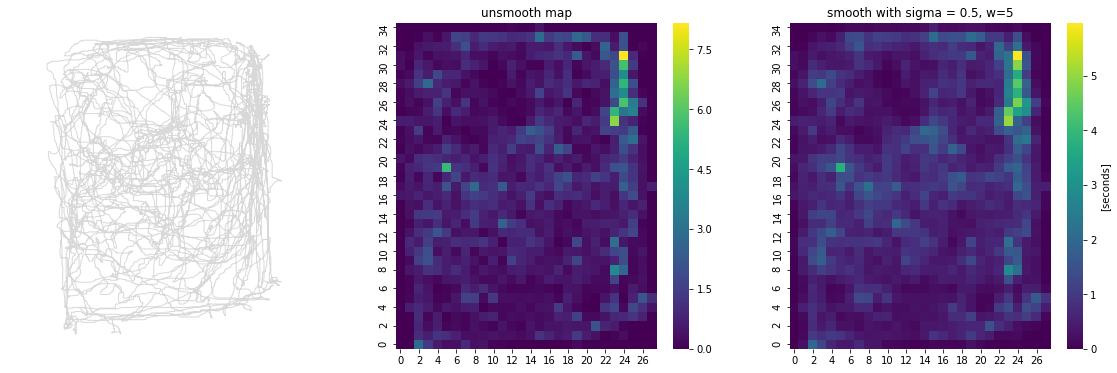

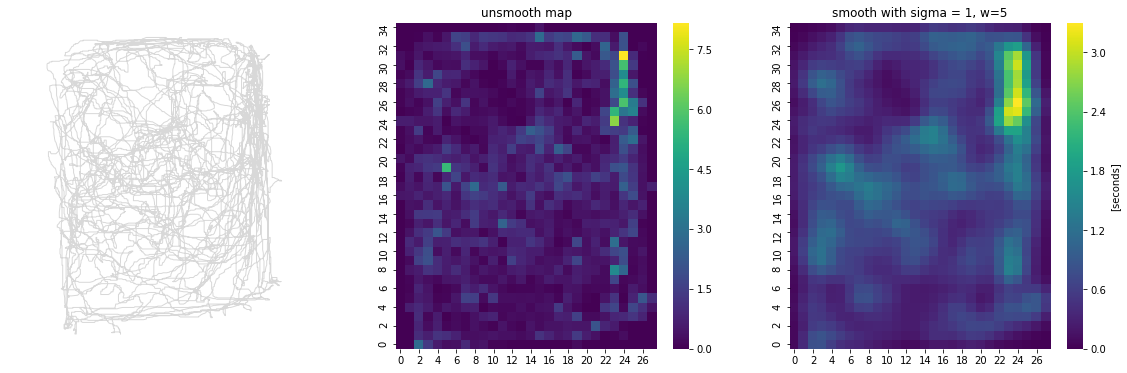

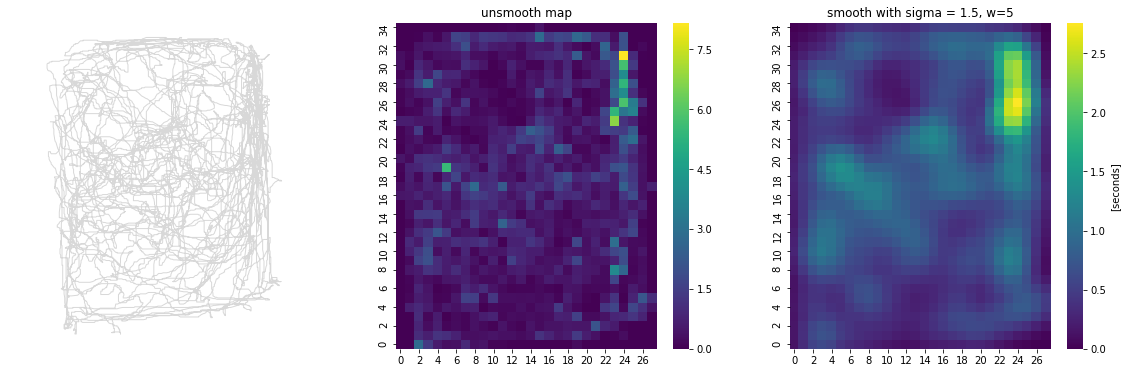

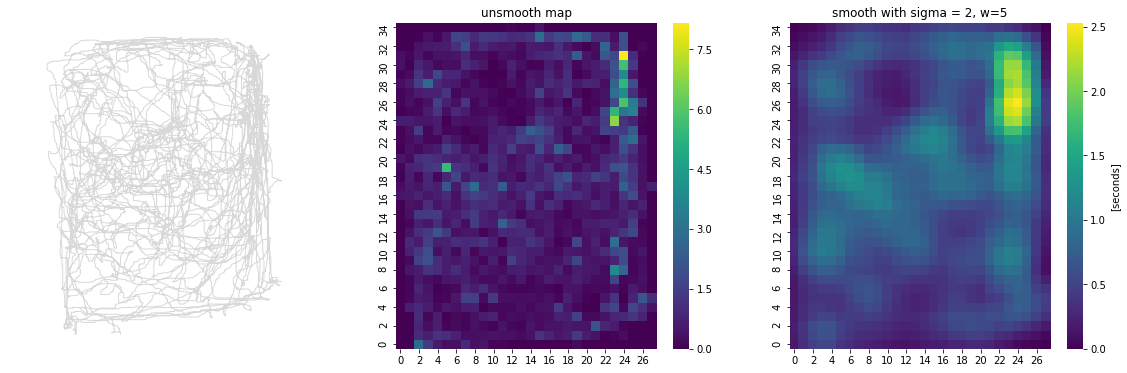

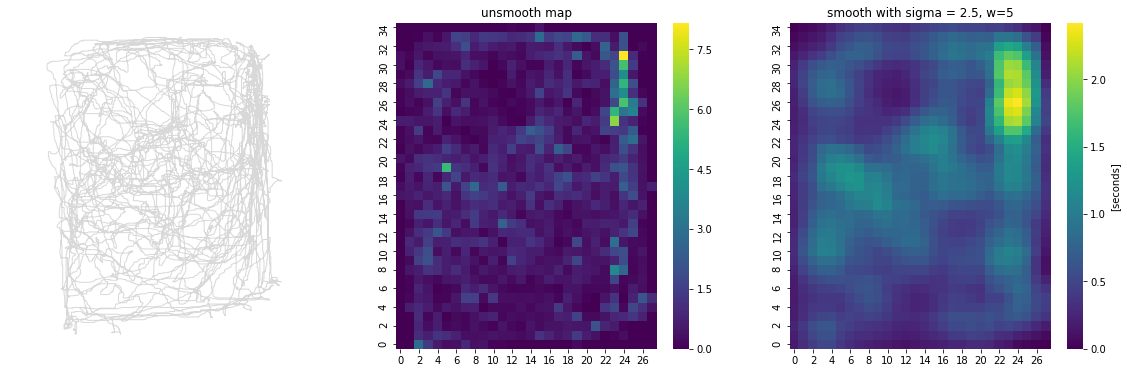

In [7]:
sigmas = [0.5, 1, 1.5, 2, 2.5]
w = 5 # number of bins    
for s in sigmas:
    f,(a1,a2,a3)=plt.subplots(1,3, figsize=(20,6))
    
    a1.plot(x2,y2,linewidth=1,color='grey',alpha=0.3)   
    a1.set_aspect('equal', adjustable='box')
    a1.set_axis_off()
    
    sns.heatmap(Time_2d,cmap='viridis',square=T,ax=a2)
    a2.invert_yaxis()
    a2.set_title('unsmooth map')
    
    psmooth = smooth_hist2d(Time_2d,w,s)
    sns.heatmap(psmooth,cmap='viridis',ax=a3,square=T, cbar_kws={'label': '[seconds]'})
    a3.set_title('smooth with sigma = {}, w={}'.format(s,w))
    a3.invert_yaxis()

#### with w=5, sigma=1-1.5,  seems to yield the best results.  going with w=5, s=1.5

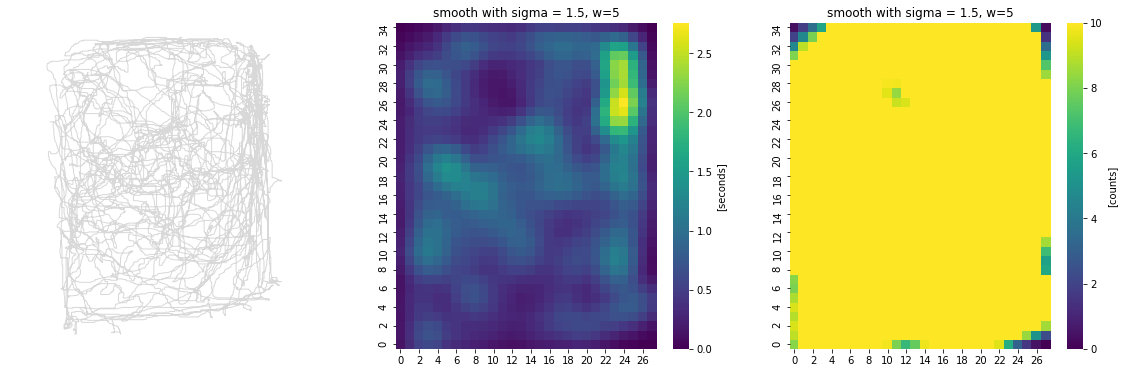

In [8]:
sigma = 1.5
w = 5 # number of bins    
f,(a1,a2,a3)=plt.subplots(1,3, figsize=(20,6))

a1.plot(x2,y2,linewidth=1,color='grey',alpha=0.3)   
a1.set_aspect('equal', adjustable='box')
a1.set_axis_off()

occupancy_time_map = smooth_hist2d(Time_2d,w,sigma)
sns.heatmap(occupancy_time_map,cmap='viridis',ax=a2,square=T, cbar_kws={'label': '[seconds]'})
a2.set_title('smooth with sigma = {}, w={}'.format(sigma,w))
a2.invert_yaxis()

occupancy_map = smooth_hist2d(position_2d,w,sigma)
sns.heatmap(occupancy_map,cmap='viridis',ax=a3,square=T, cbar_kws={'label': '[counts]'},vmax=10)
a3.set_title('smooth with sigma = {}, w={}'.format(sigma,w))
a3.invert_yaxis()


## Get Neurons for the session

In [9]:
os.chdir(str(datPath))
cl = {}
SpikeTrains = {}
time=np.arange(t[0],t[len(t)-1]+1,step=1/32000)
for tt in np.arange(1,17):
    try:
        params    = CircusParser(str(datPath)+'/tt_'+str(tt)+'.npy')
        results = load_data(params, 'results') # To load the templates
        nTemps = len(results['spiketimes'])
        #time = np.arange(97)/32
        for ti in np.arange(nTemps):
            cl['TT{}_Temp{}'.format(tt,ti)]=np.copy(results['spiketimes']['temp_{}'.format(ti)])
            SpikeTrains['TT{}_Temp{}'.format(tt,ti)]=nept.SpikeTrain(time[results['spiketimes']['temp_{}'.format(ti)]]) 
    except:
        print('Could not load template for tetrode {}'.format(tt))
        print ("error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)


### Selecting a single tetrode/cell to tune parameters.

In [10]:
#Parameters
key = 'TT2_Temp3' 
w = 5
sigma = 1.5
occupied_thresh = 0.1 # in seconds.
occupancy_mask = occupancy_time_map>occupied_thresh

trace_spikes = f_xy(SpikeTrains[key].time)
spike_bin_counts,a,b = np.histogram2d(trace_spikes[1],trace_spikes[0], bins=[yedges, xedges])
smooth_spike_counts = smooth_hist2d(spike_bin_counts,w,sigma) 

occupancy_time_map = smooth_hist2d(Time_2d,w,sigma)
occupancy_map = smooth_hist2d(position_2d,w,sigma)

spike_spatial_map = smooth_spike_counts/occupancy_time_map
occupancy_prob = occupancy_map/occupancy_map.sum()

In [11]:
def spatial_information(occupancy_prob, fr_map):
    meanFR = np.nanmean(fr_map)
    InfoMat = fr_map*occupancy_prob*np.log2(fr_map/meanFR)
    return 1/meanFR*np.nansum(InfoMat)

### try different smoothing/thresholding methods for the spatial tunning curves.

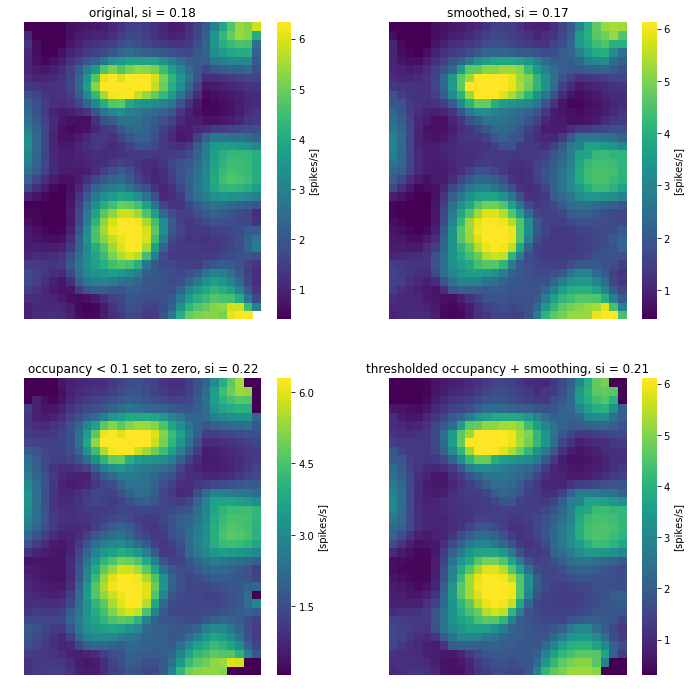

In [12]:
f,((a1,a2),(a3,a4))=plt.subplots(2,2, figsize=(12,12))

medSmooth = 3
sns.heatmap(spike_spatial_map,ax=a1,cmap='viridis',square=T, cbar_kws={'label': '[spikes/s]'},robust=True)
si = spatial_information(occupancy_prob,spike_spatial_map)
a1.set_title('original, si = {:.2f}'.format(si))
a1.invert_yaxis()
a1.set_axis_off()

spike_spatial_map2=ndimage.filters.median_filter(spike_spatial_map,medSmooth)
sns.heatmap(spike_spatial_map2,ax=a2,cmap='viridis',square=T, cbar_kws={'label': '[spikes/s]'},robust=True)
si = spatial_information(occupancy_prob,spike_spatial_map2)
a2.set_title('smoothed, si = {:.2f}'.format(si))
a2.invert_yaxis()
a2.set_axis_off()

spike_spatial_map3 = np.array(spike_spatial_map)
spike_spatial_map3[~occupancy_mask]=0
sns.heatmap(spike_spatial_map3,ax=a3,cmap='viridis',square=T, cbar_kws={'label': '[spikes/s]'},robust=True)
si = spatial_information(occupancy_prob,spike_spatial_map3)
a3.set_title('occupancy < {} set to zero, si = {:.2f}'.format(occupied_thresh,si))
a3.invert_yaxis()
a3.set_axis_off()

spike_spatial_map4=ndimage.filters.median_filter(spike_spatial_map3,medSmooth)
sns.heatmap(spike_spatial_map4,ax=a4,cmap='viridis',square=T, cbar_kws={'label': '[spikes/s]'},robust=True)
si = spatial_information(occupancy_prob,spike_spatial_map4)
a4.set_title('thresholded occupancy + smoothing, si = {:.2f}'.format(si))
a4.invert_yaxis()
a4.set_axis_off()

### thresholding and smoothing seem to give the best qualitative results. 

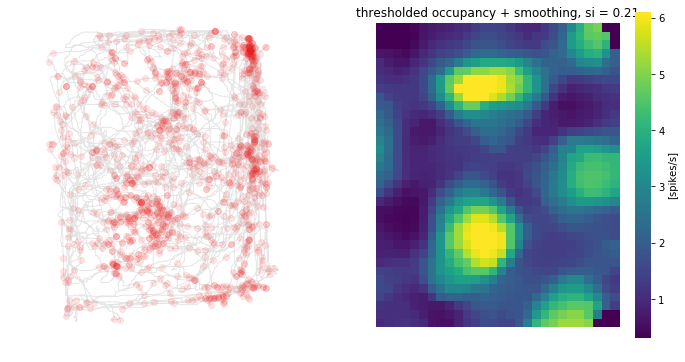

In [20]:
medSmooth = 3
trace_alpha = 0.2
spike_alpha = 0.1

spike_spatial_map3 = np.array(spike_spatial_map)
spike_spatial_map3[~occupancy_mask]=0
spike_spatial_map4=ndimage.filters.median_filter(spike_spatial_map3,medSmooth)

f,(a1,a2)=plt.subplots(1,2, figsize=(12,6))

a1.plot(x2,y2,linewidth=1,color='grey',alpha=trace_alpha)   
a1.set_aspect('equal', adjustable='box')
a1.set_axis_off()
a1.scatter(trace_spikes[0],trace_spikes[1],color='red',alpha=spike_alpha)

sns.heatmap(spike_spatial_map4,ax=a2,cmap='viridis',square=T, cbar_kws={'label': '[spikes/s]'},robust=True)
si = spatial_information(occupancy_prob,spike_spatial_map4)
a2.set_title('thresholded occupancy + smoothing, si = {:.2f}'.format(si))
a2.invert_yaxis()
a2.set_axis_off()

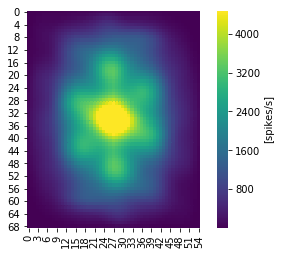

## Compute for all cells...

In [ ]:
# need to edit...
for key in SpikeTrains.keys():
    else:
        f,(a1,a2)=plt.subplots(1,2, figsize=(10,5))

    # panel a
    xy=f_xy(SpikeTrains[key].time)
    a1.plot(x2,y2,linewidth=0.5,color='grey',alpha=alpha1)
    a1.scatter(xy[0],xy[1],15, color='red',alpha=alpha2)
    a1.set_axis_off()
    a1.set_xlim(xlims[0]-step,xlims[1]+step)
    a1.set_ylim(ylims[0]-step,ylims[1]+step)

    # panel b
    tuning_curves = nept.tuning_curves.tuning_curve_2d(p, [SpikeTrains[key]], xedges, yedges,
                                         occupied_thresh=occupied_thresh, gaussian_std=sigma)

    vmax=np.percentile(tuning_curves[0].flatten(),[97.5])
    h2=sns.heatmap(tuning_curves[0],cmap='viridis',xticklabels=False,yticklabels=False,ax=a2,
                       cbar=False,robust=False,vmax=vmax)
    h2.invert_yaxis()
    a2.text(0, len(yedges)+2, 'max FR=%0.2f [sp/s]'%(vmax))

    f.savefig(str(savePath / '{}_SpatialTuning.png'.format(key)),bbox_inches='tight',dpi = 300)


## Head direction tunning.

In [14]:
def atan2v(x,y):
    N = len(y)
    out = np.zeros(N)
    for i in np.arange(N):
        out[i] = np.math.atan2(y[i],x[i])
    return out

def head_dir(x,y):
    dx = np.diff(x)
    dy = np.diff(y)
    return atan2v(dx,dy)
    
def euclidian(x,y):
     return np.sqrt(x*x+y*y)
    


(array([4.000e+00, 4.000e+00, 4.000e+00, 9.000e+00, 9.000e+00, 2.200e+01,
        2.900e+01, 6.800e+01, 1.340e+02, 1.820e+02, 3.030e+02, 5.440e+02,
        9.480e+02, 1.561e+03, 5.270e+03, 3.866e+03, 6.559e+03, 1.912e+03,
        1.096e+03, 4.740e+02, 2.080e+02, 6.000e+01, 5.900e+01, 1.900e+01,
        6.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-268.97496918, -251.589757  , -234.20454483, -216.81933265,
        -199.43412048, -182.0489083 , -164.66369613, -147.27848395,
        -129.89327178, -112.5080596 ,  -95.12284743,  -77.73763526,
         -60.35242308,  -42.96721091,  -25.58199873,   -8.19678656,
           9.18842562,   26.57363779,   43.95884997,   61.34406214,
          78.72927432,   96.11448649,  113.49969867,  130.88491084,
         148.27012302,  165.65533519,  183.04054736,  200.42575954,
         217.81097171,  23

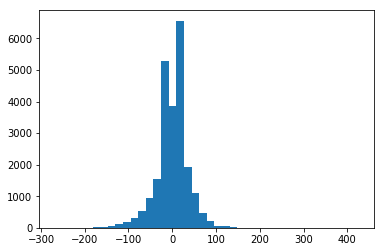

In [16]:
t0 = t[1:]
dt = np.diff(t).mean()
#spl = interpolate.UnivariateSpline(t,[x2,y2],k=3)

r = euclidian(x2,y2)
th = head_dir(x2,y2)
sp = np.diff(r)/dt
sp = 

#s_sm= interpolate.UnivariateSpline(t0,sp,k=3)
plt.hist(sp[np.abs(sp)>0.3],40)

#edges = np.arange(-np.pi,np.pi,2*np.pi/16)
#plt.hist(th)


ValueError: x and y must have same first dimension, but have shapes (100,) and (2,)

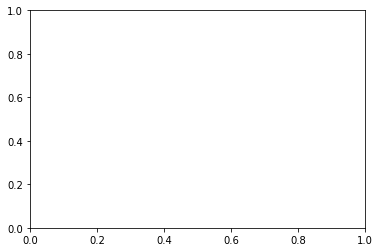

In [19]:
sp_spline = interpolate.UnivariateSpline(t0,sp,k=3)
tt =t0[:100]
plt.plot(tt,[sp,sp_spline(tt)])

In [ ]:
2

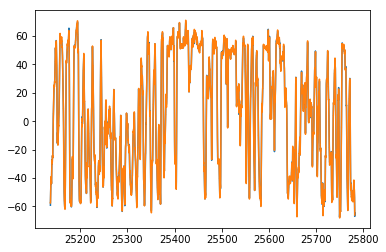

In [323]:
x_spl = interpolate.UnivariateSpline(t,x2,k=3)

plt.plot(t,spl(t))
plt.plot(t,x2)

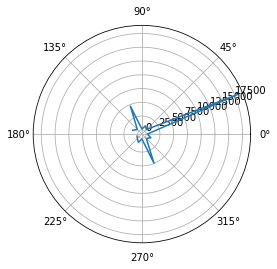

In [290]:
ax = plt.subplot(111, projection='polar')
ax.plot(angles[1:], bins)

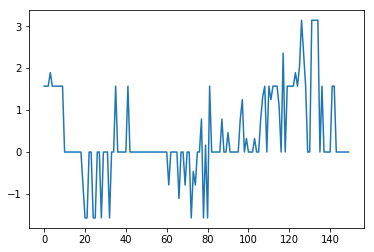

In [292]:
plt.plot(th[50:200])